# Compare adaptive solver (only forward mode) with fixed grid RK4

Adaptive solver implementation: https://www.tensorflow.org/api_docs/python/tf/contrib/integrate/odeint

In [1]:
import numpy as np
import numpy.random as npr
import tensorflow as tf
keras = tf.keras

In [2]:
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

In [3]:
class NNModuleTimeDependent(tf.keras.Model):
    def __init__(self):
        super(NNModuleTimeDependent, self).__init__(name="Module")
        self.num_filters = 3
        self.dense_1 = keras.layers.Dense(self.num_filters, activation="tanh")
        self.dense_2 = keras.layers.Dense(self.num_filters, activation="tanh")

    def call(self, inputs, **kwargs):
        t, x = inputs
        h = self.dense_1(x * t)
        return self.dense_2(h * t)

In [73]:
from neural_ode import NeuralODE
tf.set_random_seed(1234)
x0 = tf.random_normal(shape=[7, 3])
model = NNModuleTimeDependent()

In [81]:
ode = NeuralODE(model, t=np.linspace(0, 5.0, 25))
x0_grid = ode.forward(x0)

In [82]:
x0_adap, info_dict = ode.forward_odeint(x0, return_states=False)

In [83]:
tf.losses.absolute_difference(x0_adap, x0_grid)

<tf.Tensor: id=69177, shape=(), dtype=float32, numpy=8.556956e-05>

In [89]:
info_dict['num_func_evals'].numpy()

127

In [90]:
errors = []
for i in range(20):
    x0_grid = NeuralODE(model, t=np.linspace(0, 5.0, i + 1)).forward(x0)
    diff = tf.losses.absolute_difference(x0_adap, x0_grid)
    errors.append(diff)

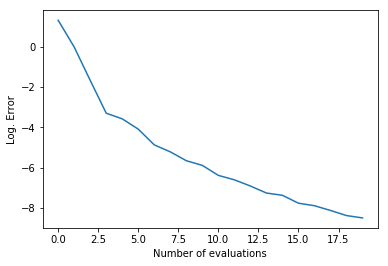

In [98]:
import matplotlib.pyplot as plt
plt.plot(np.log(errors))
plt.ylabel("Log. Error")
plt.xlabel("Number of evaluations")